<a href="https://colab.research.google.com/github/KetakiN/Sentiment_Analysis/blob/main/amz_reviews_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import nessecary modules
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc, balanced_accuracy_score
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
from scipy.stats import t
from scipy.stats import stats
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,f1_score,precision_recall_curve,balanced_accuracy_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 2.0MB 18.4MB/s 


In [ ]:
from textstat import textstat

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
pip install langdetect

     |████████████████████████████████| 983kB 6.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=a3cb96b153c74c2ecccd30b787209a7559b9ccf14be6206c3e01e88fba18c3f0
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
from langdetect import detect

In [ ]:
# upload the amazon electronics review dataset as a pandas dataframe df
df=pd.read_csv('/content/sample_data/extracted_amz.csv')
# take a look at the first two rows
df.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,3296,5,True,"06 2, 2016",A10NB19S5PPK5U,9707716371,m_t_r_86,Great product. Ran my GPS all day driving and...,Great product. Ran my GPS all day driving and ...,1464825600,NaN,NaN,NaN
1,2748,2,True,"05 27, 2017",AE5J5QK1SEQMG,9707716371,Desmond Blanchard,The term 'Buyers Remorse' describes my reactio...,The term 'Buyers Remorse' describes my reactio...,1495843200,NaN,NaN,NaN


# Language detection

In [ ]:
# create a function to detect english language reviews
def detect_lang(x):
    try:
        language = detect(x)
    except:
        language = 'unk'
    return language

In [ ]:
# apply the function to the review text
df['lang_rt'] = df['reviewText'].apply(lambda x: detect_lang(x))

In [ ]:
# check the unique languages
df.lang_rt.unique()

array(['en', 'af', 'fi', 'id', 'ca', 'fr', 'ro', 'nl', 'sl', 'sk', 'es',
       'sv', 'so', 'it', 'pt', 'et', 'de', 'cy', 'no', 'da', 'hr', 'pl',
       'vi', 'cs', 'sw', 'hu', 'tr', 'lv', 'sq', 'tl', 'unk', 'lt'],
      dtype=object)

In [ ]:
# create a column for count
df['count']=1

In [ ]:
#save file as english_amz_extracted.csv
#df.to_csv('english_amz_extracted.csv')
#files.download('english_amz_extracted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# check the number of reviews in diffierent languages
lang_reviewText=df.groupby('lang_rt')['count'].sum().reset_index()
lang_reviewText.sort_values(by='count').head()

,lang_rt,count
15,lt,19
16,lv,75
27,sw,186
11,hr,202
29,tr,214


In [ ]:
lang_reviewText.sort_values(by='count').tail()

,lang_rt,count
1,ca,3606
24,so,4542
21,ro,5682
0,af,6247
6,en,465215


In [ ]:
# From the above we can see that the dataset has approximately 500,000 rows of which 465,215 rows have english reviews, i.e the majority are english
# Next, we will only keep those reviews that are english from the dataset before further processing
df=df[df['lang_rt']=='en']

In [ ]:
#confirm the unique language in the reviews
df['lang_rt'].unique()

array(['en'], dtype=object)

In [ ]:
# check the shape of the english only dataset
df.shape

(465215, 15)

In [ ]:
# check which product asin numbers have higher number of reviews, lets look at reviews above 500 in number
(df.asin.value_counts()>500).head(7)

B00MQSMDYU     True
B005NF5NTK     True
B00X5RV14Y     True
B00QN1T6NM     True
B014EB532U     True
B00MXWFUQC    False
B00AANQLRI    False
Name: asin, dtype: bool

In [ ]:
# B00MQSMDYU is asin for https://www.amazon.com/Portable-Chargers-RAVPower-16750mAh-External/dp/B00MQSMDYU
# B005NF5NTK is asin for https://www.amazon.com/Anker-PowerCore-Lipstick-Sized-Generation-Batteries/product-reviews/B005NF5NTK
# B00X5RV14Y is asin for https://www.amazon.com/Portable-Charger-Anker-PowerCore-20100mAh/dp/B00X5RV14Y 
# B00QN1T6NM is asin for https://www.amazon.com/Maxboost-Protector-Protectors-Ballistic-Protective/dp/B00QN1T6NM
# B014EB532U is asin for https://www.amazon.com/iPhone-Screen-Protector-amFilm-Tempered/dp/B014EB532U
# B00MXWFUQCis asin for https://www.amazon.com/TaoTronics-Windshield-Dashboard-Universal-Smartphone/dp/B00MXWFUQC

Above, the asin number with thier product types have been identified as three categories: 

Power chargers :B00MQSMDYU , B005NF5NTK   ,B00X5RV14Y

Phone screen protectors:B00QN1T6NM, B014EB532U

and a Dashboard holder:B00MXWFUQC

# Text PreProcessing
normalisation

In [ ]:
# convert reviewText column string into lower case
df['reviewText_lower']=df['reviewText'].str.lower()

In [ ]:
# convert summary column string into lower case
df['summary_lower']=df['summary'].str.lower()

In [ ]:
# remove punctuation from review Text and Summary and assign punctuation in seprate columns
# define a function for extracting punctuations
def check_find_punctuations(text):
    
    # regular expression containing
    # all punctuation
    result = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', 
                        text)
      
    # form a string
    string = "".join(result)
      
    # list of strings return
    return list(string)
    



In [ ]:
# drop columns not useful, drop the rows with null values: a small fraction of the entire dataset
df=df.dropna(subset=['summary', 'reviewText'],axis=0)
df=df.drop(axis=1,columns=['vote','image','style'])

In [ ]:
# extract punctuation from review Text and Summary and assign punctuation in seprate columns
df['punct_reviewText'] = df['reviewText_lower'].apply(lambda x : check_find_punctuations(x))
df['punct_Summary'] = df['summary_lower'].apply(lambda x : check_find_punctuations(x))

                         

In [ ]:
#create a bag of words for the punctuations in the review text and summary text as bow_prt and bow_ps respectively
df['bow_prt']=df['punct_reviewText'].apply(lambda x: Counter(x))
df['bow_ps']=df['punct_Summary'].apply(lambda x: Counter(x))

In [ ]:
# create function to find number of exlamation marks in each review text and summary, and extract into column exc_prt, exc_ps respectively
def get_values(x):
  for key,value in x.items():
    if key=='!':
      return value

df['exc_prt']=df['bow_prt'].apply(lambda x: get_values(x) )
df['exc_ps']=df['bow_ps'].apply(lambda x: get_values(x))

In [ ]:
# create function to find number of ? marks in each review text and summary, and extract into column quest_prt, quest_ps respectively
def get_quest(x):
  
  for key,value in x.items():
    if key=='?':
      return value

df['quest_prt']=df['bow_prt'].apply(lambda x: get_quest(x) )
df['quest_ps']=df['bow_ps'].apply(lambda x: get_quest(x))

In [ ]:
# create function to find number of [ marks in each review text and summary, and extract into column quest_prt, quest_ps respectively
def get_quest(x):
  
  for key,value in x.items():
    if key=='(':
      return value

df['paran_prt']=df['bow_prt'].apply(lambda x: get_quest(x) )
df['paran_ps']=df['bow_ps'].apply(lambda x: get_quest(x))

In [ ]:
# create function to find number of " marks in each review text and summary, and extract into column quest_prt, quest_ps respectively
def get_quest(x):
  
  for key,value in x.items():
    if key=='"':
      return value

df['quotes_prt']=df['bow_prt'].apply(lambda x: get_quest(x) )
df['quotes_ps']=df['bow_ps'].apply(lambda x: get_quest(x))

In [ ]:
# remove numbers from review Text and Summary and assign punctuation in seprate columns
# define a function for extracting numbers
def check_find_numbers(text):
    
    # regular expression containing
    # all punctuation
    result = re.findall('[0-9]+', 
                        text)
      
    # form a string
    string = "".join(result)
      
    # list of strings return
    return list(string)

In [ ]:
# extract numbers from review Text and Summary and assign in seperate columns
df['num_reviewText'] = df['reviewText_lower'].apply(lambda x : check_find_numbers(x))
df['num_Summary'] = df['summary_lower'].apply(lambda x : check_find_numbers(x))

In [ ]:
# Replace Numeric characters with ' '
df['reviewText_clean']=df['reviewText_lower'].replace(r"[.+\d. +]", ' ',regex=True)
df['summary_clean']=df['summary_lower'].replace(r"[.+\d. +]", ' ',regex=True)

In [ ]:
#Remove Non-alphanumeric & non printable characters
df['reviewText_clean']=df['reviewText_clean'].replace(r"[^a-zA-Z0-9]", ' ',regex=True)
df['summary_clean']=df['summary_clean'].replace(r"[^a-zA-Z0-9]", ' ',regex=True)

In [ ]:
# remove multiple whitespaces to one
df['reviewText_clean']=df['reviewText_clean'].str.strip()
df['summary_clean']=df['summary_clean'].str.strip()

In [ ]:
# check added columns
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'overall', 'verified', 'reviewTime',
       'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary',
       'unixReviewTime', 'lang_rt', 'count', 'reviewText_lower',
       'summary_lower', 'punct_reviewText', 'punct_Summary', 'bow_prt',
       'bow_ps', 'exc_prt', 'exc_ps', 'quest_prt', 'quest_ps', 'paran_prt',
       'paran_ps', 'quotes_prt', 'quotes_ps', 'num_reviewText', 'num_Summary',
       'reviewText_clean', 'summary_clean'],
      dtype='object')

# Remove stop words

In [ ]:
#Removing stop words
stop = stopwords.words('english')
df['reviewText_clean']=df['reviewText_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['summary_clean']=df['summary_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


# Text Lemmatization

In [ ]:
# lemmatize review text
lemmatizer=WordNetLemmatizer()
df['summary_clean']=df['summary_clean'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split(' ')]))
#lemmatize summary text
df['reviewText_clean']=df['reviewText_clean'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split(' ')]))

#EDA

# analysis of target variable, overall rating

In [ ]:
# describe target variable
df['overall'].describe()

count    464972.000000
mean          3.897516
std           1.475284
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [ ]:
# check unique values of target variable
df['overall'].unique()

array([5, 2, 4, 1, 3])

In [ ]:
# check the column data types
df.dtypes

Unnamed: 0            int64
Unnamed: 0.1          int64
overall               int64
verified               bool
reviewTime           object
reviewerID           object
asin                 object
reviewerName         object
reviewText           object
summary              object
unixReviewTime        int64
lang_rt              object
count                 int64
reviewText_lower     object
summary_lower        object
punct_reviewText     object
punct_Summary        object
bow_prt              object
bow_ps               object
exc_prt             float64
exc_ps              float64
quest_prt           float64
quest_ps            float64
paran_prt           float64
paran_ps            float64
quotes_prt          float64
quotes_ps           float64
num_reviewText       object
num_Summary          object
reviewText_clean     object
summary_clean        object
dtype: object

In [ ]:
# count by type of rating
freq_ratings=df.groupby('overall')['count'].sum().reset_index()

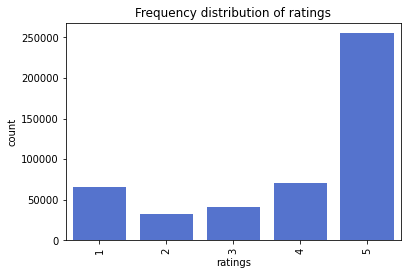

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Bar plot showing the frequency distribution of ratings
ax=sns.barplot(y='count',x='overall',data=freq_ratings,color='royalblue')
plt.setp(ax.get_xticklabels(),rotation=90)
plt.xlabel('ratings')
plt.ylabel('count')
plt.title('Frequency distribution of ratings')
plt.savefig('rating_freq.png',bbox_inches='tight')
plt.show()
files.download('rating_freq.png')

From the above graph we can observe that consumers rated products at  5 the most compared to all other ratings(1,2,3,4).

For our sentiment analysis we will categorize the target variable as positive for a rating of 5, and negative for a rating of 1,2,3,or 4.

In [ ]:
# create a new column 'sar', for sentiment analysis rating, with positive being a rating of 5, and negative being a rating of <5
conditions=[(df['overall']==5), (df['overall']<=4)]
values=['positive','negative']
df['sar']=np.select(conditions,values)

In [ ]:
df['sar'].describe()

count       464972
unique           2
top       positive
freq        255085
Name: sar, dtype: object

In [ ]:
# Lets get a percentage of how much of the dataset ratings constitute a negative and positive sentiment
negative=(df[df['sar']=='negative'])
percent_negative=((negative['sar'].value_counts()*100)/502403)
print('percentage of ratings that are negative :{}'.format(percent_negative))
positive=(df[df['sar']=='positive'])
percent_positive=((positive['sar'].value_counts()*100)/502403)
print('percentage of ratings that are positive :{}'.format(percent_positive))

percentage of ratings that are negative :Series([], Name: sar, dtype: float64)
percentage of ratings that are positive :Series([], Name: sar, dtype: float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


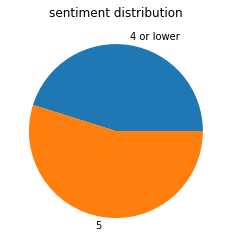

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# visualize distribution with a pie chart
data=[percent_negative,percent_positive]
labels=['4 or lower','5'] 
plt.pie(data, labels = labels)
plt.title('sentiment distribution')
plt.savefig('pie_rating.png',bbox_inches='tight')
plt.show()
files.download('pie_rating.png')

From the above percentage distribution we can see that our dataset has some imbalance with majority of the ratings with a positive sentiment for the dataset as a whole, we will also look at individual products sentiments as well as competitive products

In [ ]:
# convert sentiments to classes 1 and 0, 1 for positive, 0 for negative
dict={'positive':1,'negative':0}
df=df.replace({'sar':dict})
df.sar.unique()

array([1, 0])

# analysis of punctuations in the review text

In [ ]:
# create a dictionary of commonly uses punctuations in the review text using counter
tokens=list(chain(*df['punct_reviewText']))
counter=Counter(tokens)
counter.most_common(20)

[('.', 1393581),
 (',', 534624),
 ("'", 341865),
 ('!', 202560),
 ('-', 125322),
 (')', 57437),
 ('"', 53961),
 ('(', 52519),
 ('/', 40117),
 (':', 29362),
 ('$', 14420),
 ('&', 14039),
 ('?', 13052),
 ('=', 12256),
 ('*', 10529),
 (';', 10122),
 ('%', 9400),
 ('_', 9011),
 ('+', 6623),
 ('~', 1872)]

In [ ]:
# save top20 most used punctuations, remove punctuations that may not hold relevance to sentiment, such as period and comma
top20=counter.most_common(20)
# remove period, comma, apostrophe and space
del top20[0]
del top20[0]
del top20[0]
print(top20)

[('!', 202560), ('-', 125322), (')', 57437), ('"', 53961), ('(', 52519), ('/', 40117), (':', 29362), ('$', 14420), ('&', 14039), ('?', 13052), ('=', 12256), ('*', 10529), (';', 10122), ('%', 9400), ('_', 9011), ('+', 6623), ('~', 1872)]


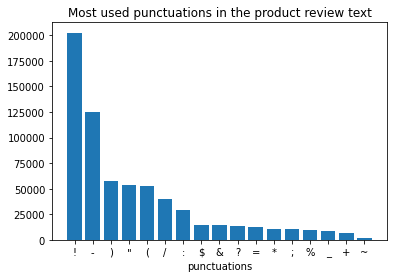

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#plot punctuations by frequency
plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
plt.xticks(range(len(top20)), [val[0] for val in top20])
plt.xlabel('punctuations')
plt.title('Most used punctuations in the product review text')
plt.savefig('common_punctuations.png',bbox_inches='tight')
plt.show()
files.download('common_punctuations.png')

In [ ]:
#previously I had created a column 'exc_prt' storing the number of exclamation marks in each review, 
# let us fill th null values in the exc_prt columns with 0
df['exc_prt']=df['exc_prt'].fillna(0)

In [ ]:
#lets us see if there is an association between sum number of punctuations and ratings
exc_sentiment=df.groupby('overall')['exc_prt'].sum().reset_index()
exc_sentiment.head()

,overall,exc_prt
0,1,27225.0
1,2,5654.0
2,3,5727.0
3,4,19291.0
4,5,144663.0


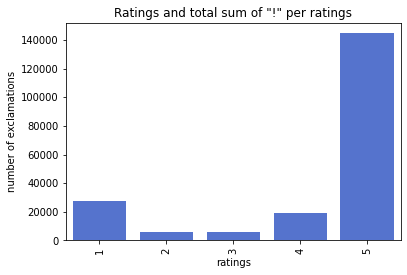

In [ ]:
# plot sum of ! per rating
ax=sns.barplot(y='exc_prt',x='overall',data=exc_sentiment,color='royalblue')
plt.setp(ax.get_xticklabels(),rotation=90)
plt.xlabel('ratings')
plt.ylabel('number of exclamations')
plt.title('Ratings and total sum of "!" per ratings')
plt.show()

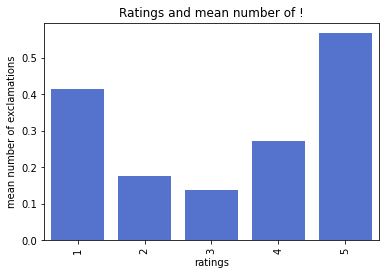

In [ ]:
#lets us see if there is an association between mean number of punctuations and ratings
exc_sentiment_mean=df.groupby('overall')['exc_prt'].mean().reset_index()
ax=sns.barplot(y='exc_prt',x='overall',data=exc_sentiment_mean,color='royalblue')
plt.setp(ax.get_xticklabels(),rotation=90)
plt.xlabel('ratings')
plt.ylabel('mean number of exclamations')
plt.title('Ratings and mean number of !')
#plt.savefig('exc_ratings.png',bbox_inches='tight')
plt.show()
#files.download('exc_ratings.png')

In [ ]:
exc_sentiment_mean.head()

,overall,exc_prt
0,1,0.413477
1,2,0.176715
2,3,0.138954
3,4,0.272345
4,5,0.567117


In [ ]:
# pull out reviews with higher number of exclamations
df_high_exc=df[df['exc_prt']>150]
df_high_exc

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,lang_rt,count,reviewText_lower,summary_lower,punct_reviewText,punct_Summary,bow_prt,bow_ps,exc_prt,exc_ps,quest_prt,quest_ps,paran_prt,paran_ps,quotes_prt,quotes_ps,num_reviewText,num_Summary,reviewText_clean,summary_clean,sar
35886,1,True,"09 8, 2014",AULFWK8TWC3JK,B006H3E6EK,Warthog,Don't know what they've done with the latest/g...,DO NOT BUY !,1410134400,en,1,don't know what they've done with the latest/g...,do not buy !,"[""'"", ""'"", '/', ""'"", '!', ""'"", '.', ""'"", '.', ...",['!'],"Counter({'!': 193, ""'"": 5, '.': 2, '/': 1, '""'...",Counter({'!': 1}),193.0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,[],[],know done latest greatest version blue parrot ...,buy,0
390580,5,True,"09 6, 2014",A1WYVMD8Y7Q7H7,B00DRSMREE,Gretchen de la Torre,"It's a very cute phone case but, it doesn't ha...",Love it,1409961600,en,1,"it's a very cute phone case but, it doesn't ha...",love it,"[""'"", ',', ""'"", '.', ',', ""'"", '.', '!', '!', ...",[],"Counter({'!': 183, ""'"": 3, ',': 2, '.': 2})",Counter(),183.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,[],[],cute phone case lip far protective picture com...,love,1


In [ ]:
# pull out a review with high number of punctuations and a negative sentiment
print(df_high_exc['reviewText'].iloc[0])

Don't know what they've done with the latest/greatest version of the Blue Parrot but it's junk !  Noise cancelling capability is good but the sound is so garbled it sound like people are talking to you with they're mouth full of oatmeal.  My older model Blue Parrot was impressive in it's sound quality.

DO NOT BUY THIS THING IT"S JUNK !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [ ]:
# pull out a review with high number of punctuations and a positive sentiment
print(df_high_exc['reviewText'].iloc[1])

It's a very cute phone case but, it doesn't have a lip. It so far is protective,the picture doesn't come off or fade. I LOVE THIS PHONE CAESE SO MUCH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [ ]:
# calculate statistical signifcance of diffrence of mean number of punctuations among different ratings
a=df[df['overall']==1]['exc_prt']
b=df[df['overall']==2]['exc_prt']
c=df[df['overall']==3]['exc_prt']
d=df[df['overall']==4]['exc_prt']
e=df[df['overall']==5]['exc_prt']

stats.f_oneway(a,b,c,d,e)

F_onewayResult(statistic=1988.585129511041, pvalue=0.0)

In [ ]:
#previously I had created a column 'quest_prt' storing the number of ? marks in each review, 
# let us fill th null values in the quest_prt columns with 0
df['quest_prt']=df['quest_prt'].fillna(0)

In [ ]:
#lets us see if there is an association between mean number of question marks and ratings
quest_sentiment=df.groupby('overall')['quest_prt'].mean().reset_index()
quest_sentiment.head()

,overall,quest_prt
0,1,0.046063
1,2,0.043569
2,3,0.038166
3,4,0.029633
4,5,0.019417


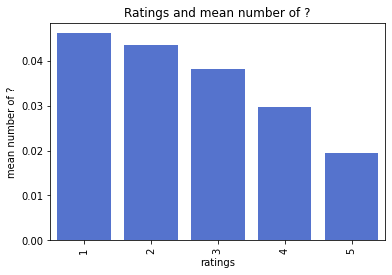

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#lets us see if there is an association between mean number of question marks and ratings
quest_sentiment_mean=df.groupby('overall')['quest_prt'].mean().reset_index()
ax=sns.barplot(y='quest_prt',x='overall',data=quest_sentiment_mean,color='royalblue')
plt.setp(ax.get_xticklabels(),rotation=90)
plt.xlabel('ratings')
plt.ylabel('mean number of ?')
plt.title('Ratings and mean number of ?')
plt.savefig('quest_ratings.png',bbox_inches='tight')
plt.show()
files.download('quest_ratings.png')

In [ ]:
# pull out reviews with higher number of question marks
df_high_quest=df[df['quest_prt']>=15]

In [ ]:
df_high_quest.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,lang_rt,count,reviewText_lower,summary_lower,punct_reviewText,punct_Summary,bow_prt,bow_ps,exc_prt,exc_ps,quest_prt,quest_ps,paran_prt,paran_ps,quotes_prt,quotes_ps,num_reviewText,num_Summary,reviewText_clean,summary_clean,sar
13380,1,True,"10 7, 2012",A396IN6GT6TLM8,B0042I3UJE,MALCOLM grupel,I purchased the goods on the 3 rd September 20...,purchased good not received,1349568000,en,1,i purchased the goods on the 3 rd september 20...,purchased good not received,"[',', '?', '?', '?', '?', '?', '?', '?', '?', ...",[],"Counter({'?': 25, ',': 1})",Counter(),0.0,NaN,25.0,NaN,NaN,NaN,NaN,NaN,"['3', '2', '0', '1', '2', '7', '2', '0', '1', ...",[],purchased good rd september date received good...,purchased good received,0
43809,3,False,"11 15, 2013",A3GVYBCZIRPLFC,B00804T8A6,NlGHTgirl,This phone has fallen out of teeny tiny hand p...,OK!,1384473600,en,1,this phone has fallen out of teeny tiny hand p...,ok!,"['!', '!', '!', '!', '""', '""', ',', ',', ',', ...",['!'],"Counter({'.': 41, '!': 28, ',': 20, '?': 15, ""...",Counter({'!': 1}),28.0,1.0,15.0,NaN,6.0,NaN,4.0,NaN,"['0', '2', '9', '1', '2', '5', '0', '0', '7', ...",[],phone fallen teeny tiny hand purse repeatedly ...,ok,0


In [ ]:
# pull out a review with high number of question marks and a negative sentiment
print(df_high_quest['reviewText'].iloc[0])

I purchased the goods on the 3 rd September 2012 and to date I not received the goods, no the 7th October 2012?????????????????????????

Why
Malcolm


In [ ]:
# pull out reviews with lower number of question marks
df_low_quest=df[df['quest_prt']==1]

In [ ]:
# pull out a review with lower number of question marks and a positive sentiment
print(df_low_quest['reviewText'].iloc[4])

I will not belabor the technical aspects of this phone--but I will sing higest praises to Nokia for making it available in the U.S. Now, if Americans would avail themselves of the data functions of this phone and not just the voice, AT&T, T-Mobile and Cingular "Internet" dl/ul prices would be cheaper.
This is, simply put, the best phone on the market to date!  The camera is great, that it shoots short videos is amazing, and couple it with the very comfortable Jabra Bluetooth headset, and you have a true deal that even P.T. Barnum himself would be envious of.
There are other phones with more vivid colors or larger screens, etc., but you get so much more phone than any other is capable of today (in the US).  You can't go wrong--and it's free!  How can you beat it?  You can't.


In [ ]:
# to check statistical significance we are going to to an independent t tesst between ratings 5 and 4
a=df[df['overall']==5]['quest_prt']
b=df[df['overall']==4]['quest_prt']
stats.ttest_ind(a,b)

Ttest_indResult(statistic=-11.281101220171008, pvalue=1.647618168408688e-29)

In [ ]:
# calculate statistical signifcance of diffrence of mean number of question marks among different ratings
c=df[df['overall']==3]['quest_prt']
d=df[df['overall']==2]['quest_prt']
e=df[df['overall']==1]['quest_prt']

stats.f_oneway(a,b,c,d,e)

F_onewayResult(statistic=209.88804780912878, pvalue=3.0284292029718455e-180)

In [ ]:
# save the dataframe with new added columns for our target variable 
#df.to_csv('eng_amz_clean1.csv',index=False)
#files.download('eng_amz_clean1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# creating an identity matrix

In [ ]:
#df=pd.read_csv('/content/sample_data/eng_amz_clean1.csv')

In [ ]:
#df=df.drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis=1)

In [ ]:
#df=df.dropna(subset=['reviewText_clean'],axis=0)

In [ ]:
# create a vectorizer on the entire vocabulary df['reviewText_clean] of the dataset
X=df['reviewText_clean']
y=df['sar']

In [ ]:
# train a classifier 
vectorizer=TfidfVectorizer(min_df=50)
tfidf_train=vectorizer.fit_transform(X)
clf = MultinomialNB().fit(tfidf_train,y)
# Print the first 10 features
print(vectorizer.get_feature_names()[:10])


['aa', 'aaa', 'ab', 'ability', 'able', 'abroad', 'absolute', 'absolutely', 'absorb', 'absorbed']


In [ ]:
# predict which words are most predictive and least predictive for the positive class in 'cell phones and accesories'
words = np.array(vectorizer.get_feature_names())
x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
            exceeded 0.93
              highly 0.91
            organize 0.91
           delighted 0.91
            excelent 0.90
           invention 0.90
         outstanding 0.89
             perfect 0.89
                 fav 0.89
          invaluable 0.89
Bad words	     P(fresh | word)
        dissatisfied 0.06
                wast 0.06
            horrible 0.06
              poorly 0.05
             garbage 0.05
        unacceptable 0.05
       disappointing 0.05
               froze 0.04
           worthless 0.04
               waste 0.04


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

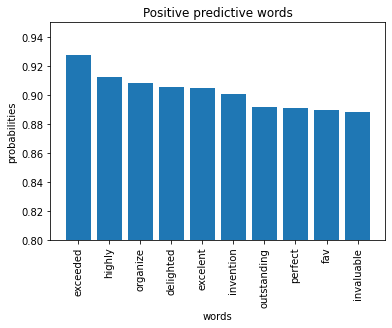

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for positive sentiment
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'])
plt.xticks(rotation=90)
plt.xlabel('words')
plt.ylabel('probabilities')
plt.title('Positive predictive words')
plt.ylim(0.80,0.95)
plt.savefig('overall_positive.png',bbox_inches='tight')
plt.show()
files.download('overall_positive.png')

In [ ]:
# predict which words are most predictive and least predictive for the negative class for 'cell phones and accessories'
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 1]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
               waste 0.96
           worthless 0.96
               froze 0.96
       disappointing 0.95
        unacceptable 0.95
             garbage 0.95
              poorly 0.95
            horrible 0.94
                wast 0.94
        dissatisfied 0.94
Bad words	     P(fresh | word)
          invaluable 0.11
                 fav 0.11
             perfect 0.11
         outstanding 0.11
           invention 0.10
            excelent 0.10
           delighted 0.09
            organize 0.09
              highly 0.09
            exceeded 0.07


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

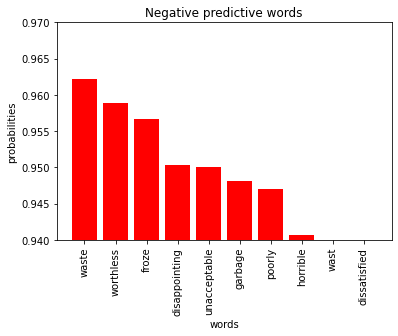

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for negative sentiment
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'], color='red')
plt.xticks(rotation=90)
plt.xlabel('words')
plt.ylabel('probabilities')
plt.title('Negative predictive words')
plt.ylim(0.94,0.97)
plt.savefig('overall_negative.png',bbox_inches='tight')
plt.show()
files.download('overall_negative.png')

In [ ]:
# create a smaller dataframe withe 3 types of products, a power charger, a screen protector and a dashboard holder  
df_select=df[(df['asin']=='B00MQSMDYU')|(df['asin']=='B00QN1T6NM')|(df['asin']=='B00MXWFUQC')]

In [ ]:
# create a dataframe where the above asins are not included
df_unselect=df[df['asin']!='B00MQSMDYU']
df_unselect=df_unselect[df_unselect['asin']!='B00QN1T6NM']
df_unselect=df_unselect[df_unselect['asin']!='B00MXWFUQC']


In [ ]:
# replace df_unselect asin value with 'other'
df_unselect=df_unselect.drop(columns='asin',axis=1)

In [ ]:
df_unselect['asin']='other'

In [ ]:
# create a dataframe where df_select and df_unselect are stacked into one dataframe, where only the select product asins are preserved
# and the rest asins are other
df_prdts=pd.concat([df_select, df_unselect],ignore_index=True)

In [ ]:
# create a dict with the type of product associated with the product asin
dict={'B00MQSMDYU':'power_charger','B00MXWFUQC':'dashboard_holder','B00QN1T6NM':'screen_protector','other':'other'}
df_prdts=df_prdts.replace({'asin':dict})
# create a target column of labels denoting good or bad ratied product based on the rating column
df_prdts['labels']=df_prdts['sar']

In [ ]:
# create the label names
conditions = [df_prdts['asin'].eq('power_charger') & df_prdts['labels'].eq(0),
              df_prdts['asin'].eq('power_charger') & df_prdts['labels'].eq(1),
              df_prdts['asin'].eq('screen_protector') & df_prdts['labels'].eq(0),
              df_prdts['asin'].eq('screen_protector') & df_prdts['labels'].eq(1),
              df_prdts['asin'].eq('dashboard_holder') & df_prdts['labels'].eq(0),
              df_prdts['asin'].eq('dashboard_holder') & df_prdts['labels'].eq(1),
              df_prdts['asin'].eq('other') & df_prdts['labels'].eq(0),
              df_prdts['asin'].eq('other') & df_prdts['labels'].eq(1)]

              
 
choices = ['bad_pc','good_pc','bad_sp','good_sp','bad_dh','good_dh','bad_other','good_other']
 
df_prdts['labels_new'] = np.select(conditions, choices, default= df_prdts['labels'] )

In [ ]:
# check for the unique label names
df_prdts.labels_new.unique()

array(['good_pc', 'bad_pc', 'bad_dh', 'good_dh', 'bad_sp', 'good_sp',
       'good_other', 'bad_other'], dtype=object)

In [ ]:
dict3={'bad_pc':0, 'good_pc':1, 'bad_dh':2, 'good_dh':3, 'bad_sp':4, 'good_sp':5,'bad_other':6,'good_other':7}
df_prdts=df_prdts.replace({'labels_new':dict3})

In [ ]:
# create a vectorizer on the entire vocabulary df['reviewText_clean] of the dataset df_select
X=df_prdts['reviewText_clean']
y=df_prdts['labels_new']

In [ ]:
# train a classifier 
vectorizer=TfidfVectorizer(min_df=50)
tfidf_train=vectorizer.fit_transform(X)
clf = MultinomialNB().fit(tfidf_train,y)
# Print the first 10 features
print(vectorizer.get_feature_names()[:10])


['aa', 'aaa', 'ab', 'ability', 'able', 'abroad', 'absolute', 'absolutely', 'absorb', 'absorbed']


In [ ]:
df_prdts.groupby('asin')['count'].sum().reset_index().sort_values(by='count').head()

,asin,count
0,dashboard_holder,476
3,screen_protector,526
2,power_charger,646
1,other,463269


In [ ]:
#0: good_dh
#1:bad_dh
#2:good_sp
#3:bad_sp
#4: good charger
#5:bad charger
#6:good other
#7: bad_other




In [ ]:
# predict which words are most predictive and least predictive for the positive class for good power charger
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 4]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))


Good words	     P(fresh | word)
                case 1.00
                love 1.00
              charge 1.00
               great 1.00
               color 1.00
             battery 1.00
             charger 1.00
             perfect 1.00
                well 1.00
             quality 1.00
Bad words	     P(fresh | word)
            sluggish 0.99
            directed 0.99
      aforementioned 0.99
          subjective 0.99
            monetary 0.99
             federal 0.99
           afterward 0.99
                hspa 0.99
          snapdragon 0.99
         registering 0.99


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

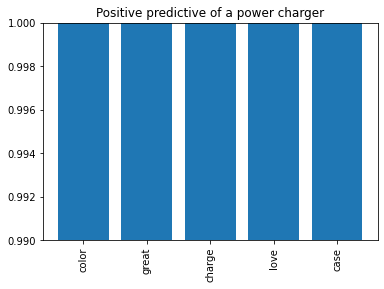

In [ ]:
# predictive words for positive sentiment for power charger
data_tail=predictive_words.tail(5)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'])
plt.xticks(rotation=90)
plt.title('Positive predictive of a power charger')
plt.savefig('power_positive.png',bbox_inches='tight')
plt.show()
files.download('power_positive.png')

In [ ]:
# predict which words are most predictive and least predictive for the negative class for power charger
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 5]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))


Good words	     P(fresh | word)
                case 1.00
               color 1.00
             battery 1.00
             charger 1.00
              charge 1.00
                cute 1.00
               cable 1.00
            charging 1.00
                card 1.00
              little 1.00
Bad words	     P(fresh | word)
             sincere 0.99
            sluggish 0.99
                hspa 0.98
      aforementioned 0.98
          subjective 0.98
            monetary 0.98
             federal 0.98
          standpoint 0.98
          snapdragon 0.98
            maxboost 0.98


In [ ]:
# predict which words are most predictive and least predictive for the positive class for good screen protector
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 2]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))


Good words	     P(fresh | word)
                case 1.00
                love 1.00
              screen 1.00
           protector 1.00
             perfect 1.00
               color 1.00
             battery 1.00
                 fit 1.00
                fast 1.00
               cover 1.00
Bad words	     P(fresh | word)
            sluggish 0.99
                hspa 0.99
      aforementioned 0.99
               rinse 0.99
          subjective 0.99
            monetary 0.99
             federal 0.99
             climate 0.99
            reattach 0.99
          snapdragon 0.99


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

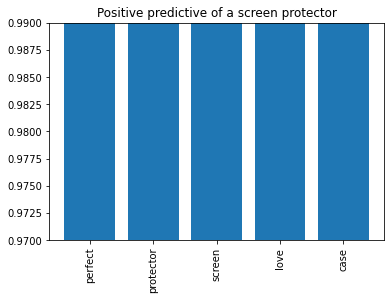

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for positive sentiment for screen protector
data_tail=predictive_words.tail(5)
plt.bar(data_tail['words'],data_tail['probs'])
plt.xticks(rotation=90)
plt.ylim(0.97,0.99)
plt.title('Positive predictive of a screen protector')
plt.savefig('sp_positive.png',bbox_inches='tight')
plt.show()
files.download('sp_positive.png')

# compare by positive or negative predictive words by product type by working on specfic rows for that product type only
power charger

screen protector

dashboard holder

power charger

In [ ]:
df_PowerCharger=df[df['asin']=='B00MQSMDYU']


In [ ]:
# create a vectorizer on the entire vocabulary df_PowerCharger['reviewText_clean] of the dataset
X=df_PowerCharger['reviewText_clean']
y=df_PowerCharger['sar']
# train a classifier 
vectorizer=TfidfVectorizer(min_df=50)
tfidf_train=vectorizer.fit_transform(X)
clf = MultinomialNB().fit(tfidf_train,y)
# Print the first 10 features
print(vectorizer.get_feature_names()[:10])
# predict which words are most predictive and least predictive for the positive class
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

['also', 'battery', 'bought', 'charge', 'charged', 'charger', 'charging', 'day', 'device', 'fast']
Good words	     P(fresh | word)
                love 0.91
                fast 0.89
            ravpower 0.85
             product 0.84
                 day 0.84
               great 0.84
                also 0.83
                time 0.83
                well 0.82
             battery 0.82
Bad words	     P(fresh | word)
              iphone 0.75
                good 0.74
              bought 0.74
                 two 0.69
                used 0.68
                 one 0.67
               would 0.66
                take 0.66
            charging 0.62
               month 0.40


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

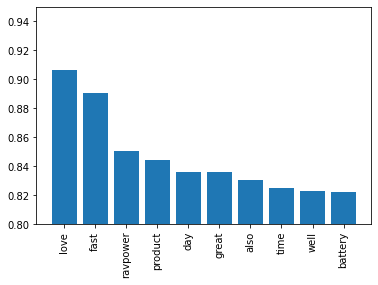

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for positive sentiment for the Rav Power Charger
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'])
plt.xticks(rotation=90)
plt.ylim(0.8,0.95)
plt.savefig('rav_positive.png',bbox_inches='tight')
plt.show()
files.download('rav_positive.png')


In [ ]:
# predict which words are most predictive and least predictive for the negative class
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 1]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
               month 0.60
            charging 0.38
                take 0.34
               would 0.34
                 one 0.33
                used 0.32
                 two 0.31
              bought 0.26
                good 0.26
              iphone 0.25
Bad words	     P(fresh | word)
             battery 0.18
                well 0.18
                time 0.17
                also 0.17
               great 0.16
                 day 0.16
             product 0.16
            ravpower 0.15
                fast 0.11
                love 0.09


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

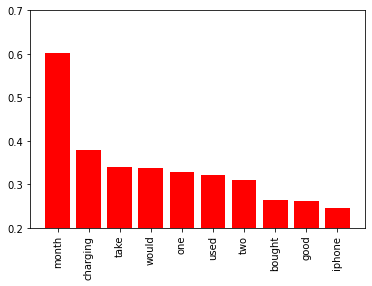

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for negative sentiment for the Rav Power Charger
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'], color='red')
plt.xticks(rotation=90)
plt.ylim(0.2,0.7)
plt.savefig('rav_negative.png',bbox_inches='tight')
plt.show()
files.download('rav_negative.png')

# I am interested in understanding why 'iphone' has a probability of a negative sentinent and I will explote some reviews conatining the word iphone

In [ ]:
# convert review text clean into a list of words, words_rt
df_PowerCharger['words_rt']=df_PowerCharger['reviewText_clean'].apply(lambda x: x.split())

In [ ]:
# define a function to find the word 'iphone'
def get_iphone(sent):
  
  for word in sent:
    if word=='iphone':
      return ('found')
    else:
      return('not found')
    
    

In [ ]:
# create a column which denotes found or not whenver the word iphone is in a review
df_PowerCharger['iphone_text'] = df_PowerCharger['words_rt'].apply(lambda x : get_iphone(x))

In [ ]:
df_PowerCharger.iphone_text.unique()

array(['not found', 'found'], dtype=object)

In [ ]:
(df_PowerCharger[df_PowerCharger['iphone_text']=='found'])['reviewText'].head(1)

176674    IPhone adapter not fit
Name: reviewText, dtype: object

screen protector

In [ ]:
df_ScrnProt=df[df['asin']=='B00QN1T6NM']


In [ ]:
# create a vectorizer on the entire vocabulary df_ScrnProt['reviewText_clean] of the dataset
X=df_ScrnProt['reviewText_clean']
y=df_ScrnProt['sar']
# train a classifier 
vectorizer=TfidfVectorizer(min_df=50)
tfidf_train=vectorizer.fit_transform(X)
clf = MultinomialNB().fit(tfidf_train,y)
# Print the first 10 features
print(vectorizer.get_feature_names()[:10])
# predict which words are most predictive and least predictive for the positive class
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

['crack', 'cracked', 'dropped', 'easy', 'glass', 'good', 'great', 'iphone', 'one', 'phone']
Good words	     P(fresh | word)
               great 0.83
                easy 0.76
                 put 0.65
             product 0.64
                work 0.63
              iphone 0.62
                time 0.62
           protector 0.62
             dropped 0.59
                good 0.59
Bad words	     P(fresh | word)
                time 0.62
           protector 0.62
             dropped 0.59
                good 0.59
               phone 0.58
              screen 0.57
                 one 0.57
               glass 0.56
               crack 0.50
             cracked 0.39


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

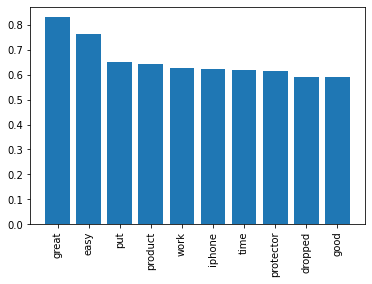

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for positive sentiment for the Screen Protector 
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'])

plt.xticks(rotation=90)
plt.savefig('maxboost_predictive.png',bbox_inches='tight')
plt.show()
files.download('maxboost_predictive.png')


In [ ]:
# predict which words are most predictive and least predictive for the negative class
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 1]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

Good words	     P(fresh | word)
             cracked 0.61
               crack 0.50
               glass 0.44
                 one 0.43
              screen 0.43
               phone 0.42
                good 0.41
             dropped 0.41
           protector 0.38
                time 0.38
Bad words	     P(fresh | word)
                good 0.41
             dropped 0.41
           protector 0.38
                time 0.38
              iphone 0.38
                work 0.37
             product 0.36
                 put 0.35
                easy 0.24
               great 0.17


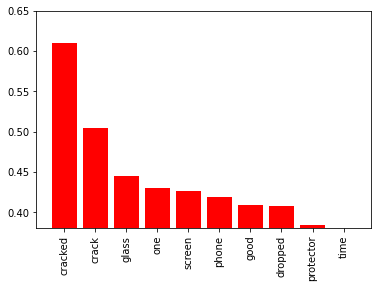

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for negative sentiment for Screen Protector
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'], color='red')
plt.xticks(rotation=90)
plt.ylim(.38,0.65)
plt.xticks(rotation=90)
plt.savefig('maxboost_negative.png',bbox_inches='tight')
plt.show()
files.download('maxboost_negative.png')



dashboard holder

In [ ]:
df_DashHolder=df[df['asin']=='B00MXWFUQC']


In [ ]:
# create a vectorizer on the entire vocabulary df_DashHolder['reviewText_clean] of the dataset
X=df_DashHolder['reviewText_clean']
y=df_DashHolder['sar']
# train a classifier 
vectorizer=TfidfVectorizer(min_df=50)
tfidf_train=vectorizer.fit_transform(X)
clf = MultinomialNB().fit(tfidf_train,y)
# Print the first 10 features
print(vectorizer.get_feature_names()[:10])
# predict which words are most predictive and least predictive for the positive class
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

['broke', 'car', 'cup', 'dash', 'dashboard', 'good', 'great', 'hold', 'holder', 'like']
Good words	     P(fresh | word)
               great 0.76
               mount 0.70
                hold 0.62
               phone 0.62
                work 0.60
              holder 0.59
                 car 0.58
             product 0.56
                 one 0.54
                good 0.53
Bad words	     P(fresh | word)
                well 0.52
          windshield 0.50
                like 0.44
                dash 0.43
             suction 0.34
                 cup 0.31
               stick 0.29
           dashboard 0.29
               month 0.25
               broke 0.13


In [ ]:
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

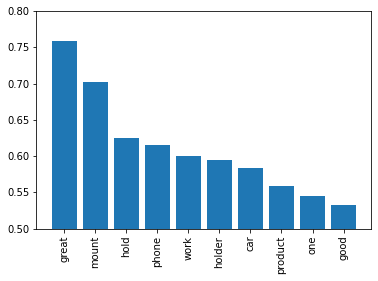

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for positive sentiment for the cellphone Dashboard Holder
data_tail=predictive_words.tail(10)
data_tail=data_tail.sort_values('probs',ascending=False)
plt.bar(data_tail['words'],data_tail['probs'])
plt.xticks(rotation=90)
plt.ylim(0.5,0.8)
plt.savefig('dash_good.png',bbox_inches='tight')
plt.show()
files.download('dash_good.png')


In [ ]:
# predict which words are most predictive and least predictive for the negative class
words = np.array(vectorizer.get_feature_names())

x = np.eye(tfidf_train.shape[1])
probs = clf.predict_log_proba(x)[:, 1]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
predictive_words=pd.DataFrame()
predictive_words['words']=words
predictive_words['probs']=1-np.exp(probs)
predictive_words=predictive_words.sort_values(by='probs').reset_index()

Good words	     P(fresh | word)
             cracked 0.61
               crack 0.50
               glass 0.44
                 one 0.43
              screen 0.43
               phone 0.42
                good 0.41
             dropped 0.41
           protector 0.38
                time 0.38
Bad words	     P(fresh | word)
                good 0.41
             dropped 0.41
           protector 0.38
                time 0.38
              iphone 0.38
                work 0.37
             product 0.36
                 put 0.35
                easy 0.24
               great 0.17


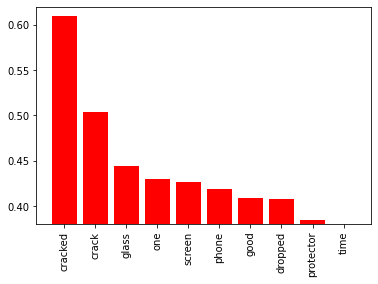

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# predictive words for negative sentiment for the cellphone Dashboard Holder
data_head=predictive_words.tail(10)
data_head=data_head.sort_values('probs',ascending=False)
plt.bar(data_head['words'],data_head['probs'],color='red')
plt.xticks(rotation=90)
plt.ylim(0.38,0.62)
plt.savefig('dash_bad.png',bbox_inches='tight')
plt.show()
files.download('dash_bad.png')

# Before Further analysis and modeling, we are going to take into consideration 2 parts of the dataset
1)The first is the 'top6' dataset consists of asin/products which have the highest number of review counts, i.e 500 counts or more

2)The second data set is a 10% random fraction of the original dataset which is approximately 500,000 rows. We will use the 'dataset_subset'  which will be approximately 50,000 rows for an overall sentiment analysis irrespective of product type


In [ ]:
# Create a 10% random sample from the cleaned dataset df, store it as df_subset
df_subset=df.sample(frac=0.10, random_state=22).reset_index()

In [ ]:
df_subset.shape

(46497, 31)

In [ ]:
# save this dataframe as a local .csv file for further use
df_subset.to_csv('df_subset.csv',index=False)
files.download('df_subset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Create a dataframe with products having atleast 500 reviews or more from the original dataset, store it as top6
# take a look at the top6 by count asin/products
top6=df[df.groupby('asin')['asin'].transform('size') >500]


# Looking at the top6

In [ ]:
# which are these top6 asin/products
top6.asin.value_counts()

B00MQSMDYU    646
B005NF5NTK    606
B00X5RV14Y    579
B00QN1T6NM    522
B014EB532U    503
Name: asin, dtype: int64

In [ ]:
# identify the product
# B00MQSMDYU is asin for https://www.amazon.com/Portable-Chargers-RAVPower-16750mAh-External/dp/B00MQSMDYU
# B005NF5NTK is asin for https://www.amazon.com/Anker-PowerCore-Lipstick-Sized-Generation-Batteries/product-reviews/B005NF5NTK
# B00X5RV14Y is asin for https://www.amazon.com/Portable-Charger-Anker-PowerCore-20100mAh/dp/B00X5RV14Y 
# B00QN1T6NM is asin for https://www.amazon.com/Maxboost-Protector-Protectors-Ballistic-Protective/dp/B00QN1T6NM
# B014EB532U is asin for https://www.amazon.com/iPhone-Screen-Protector-amFilm-Tempered/dp/B014EB532U
# B00MXWFUQC is asin for https://www.amazon.com/TaoTronics-Windshield-Dashboard-Universal-Smartphone/dp/B00MXWFUQC

In [ ]:
# save the top6 as a local .csv file for further use
#top6.to_csv('top6.csv',index=False)
#files.download('top6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install wordcloud

In [ ]:
# generate wordclouds for similar asin categories
# function for wordcloud
def generate_wordcloud(data,title):
  wordcloud = WordCloud(
    colormap='Dark2',
    max_words = 200, max_font_size = 40, 
        scale = 3,
        random_state = 42).generate(str(data))

  fig = plt.figure(1, figsize = (10, 10))
  plt.axis('off')
  plt.title(title)
  plt.imshow(wordcloud)
  plt.show()
    

In [ ]:
RavPower=df[df['asin']=='B00MQSMDYU']['reviewText']
AnkerStick=df[df['asin']=='B005NF5NTK']['reviewText']
AnkerCore=df[df['asin']=='B00X5RV14Y']['reviewText']
MaxBoostProtector=df[df['asin']=='B00QN1T6NM']['reviewText']
amFilmProtector=df[df['asin']=='B014EB532U']['reviewText']
TTDash_holder=df[df['asin']=='B00MXWFUQC']['reviewText']


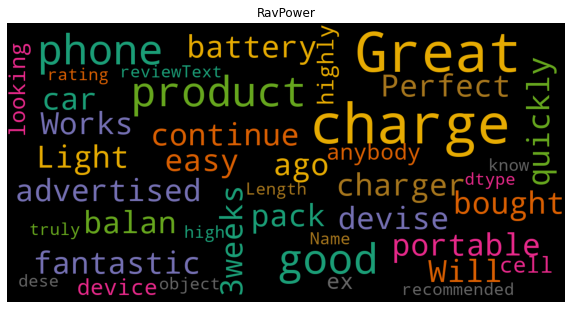

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cloud = WordCloud(
    colormap='Dark2',
    max_words = 200, max_font_size = 40, 
        scale = 3,
        random_state = 42).generate(str(RavPower))

fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.title('RavPower')
plt.imshow(cloud)
plt.savefig('ravpower_cloud.png')
plt.show()
files.download('ravpower_cloud.png')

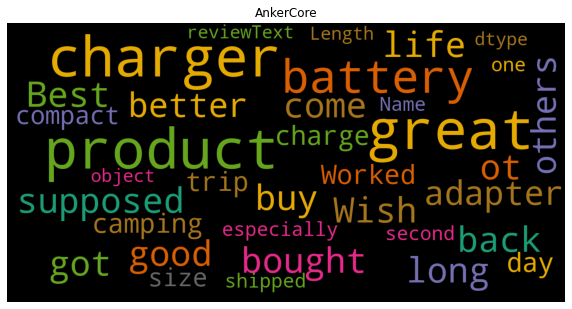

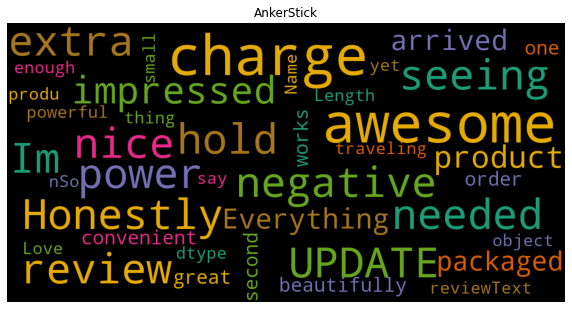

In [ ]:
# word clouds for the other portable chargers
generate_wordcloud(AnkerCore,'AnkerCore')
generate_wordcloud(AnkerStick,'AnkerStick')

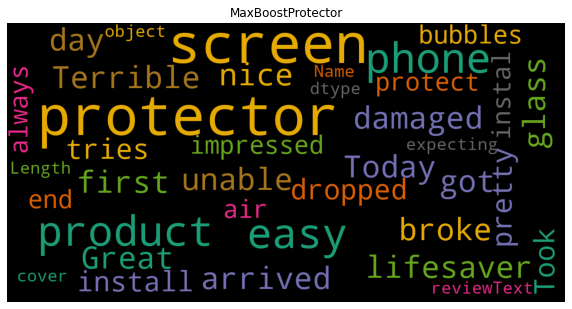

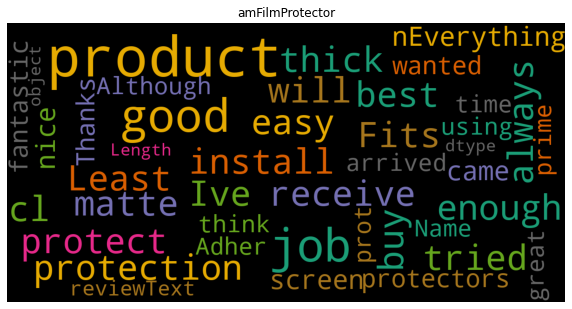

In [ ]:
# word clouds for the screen protectors
generate_wordcloud(MaxBoostProtector,'MaxBoostProtector')
generate_wordcloud(amFilmProtector,'amFilmProtector')


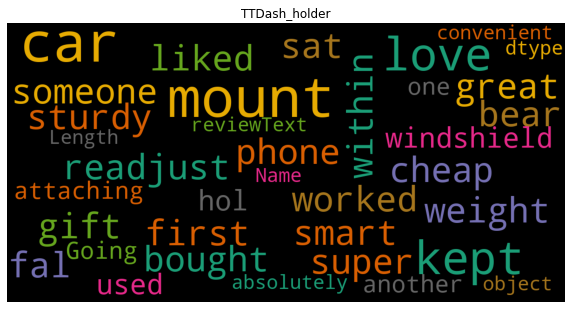

In [ ]:
# wordcloud for the phone holder on dashboard
generate_wordcloud(TTDash_holder,'TTDash_holder')

In [ ]:
# create word tokens for all of the reviewText and create a counter for each word
def my_tokenizer(text):
  return text.split() if text !=None else []
top6_tokens=top6.reviewText_clean.map(my_tokenizer).sum()
top6_counter=Counter(top6_tokens)

In [ ]:
# look at the top 20 most common words used in the reviewText for the top6 dataset
top6_counter.most_common(20)

[('phone', 1566),
 ('charge', 1479),
 ('great', 1088),
 ('screen', 1017),
 ('product', 906),
 ('one', 889),
 ('time', 808),
 ('work', 721),
 ('protector', 719),
 ('charger', 636),
 ('battery', 602),
 ('iphone', 500),
 ('use', 478),
 ('good', 463),
 ('well', 437),
 ('would', 436),
 ('easy', 430),
 ('like', 382),
 ('power', 351),
 ('device', 347)]

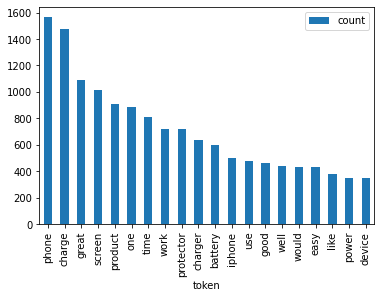

In [ ]:
# plot the top 20 used words
top6_word_freq=pd.DataFrame.from_records(top6_counter.most_common(20),columns=['token','count'])
top6_word_freq.plot(kind='bar',x='token',y='count')

In [ ]:
# check the number of words in each reviewText of the top6
top6['words_reviewText']=top6['reviewText'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
top6['words_reviewText'].describe()

count    3545.000000
mean       37.743018
std        51.580015
min         1.000000
25%         8.000000
50%        22.000000
75%        47.000000
max       753.000000
Name: words_reviewText, dtype: float64

In [ ]:
# check for word count influence in overall rating
word_sar_top6=top6.groupby('overall')['words_reviewText'].mean().reset_index()

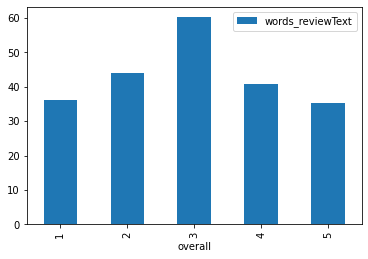

In [ ]:
# plot the mean word count of reviewText's by rating
word_sar_top6.plot(kind='bar',x='overall',y='words_reviewText')

Looks like the rating of 3, which is neutral has the highest number of word counts in the reviewText

# For modeling we will work with a 10% random fraction of the project datset: df_subset which is 46,352 rows, compared to the project dataset which is closer to 500,000 rows

In [ ]:
#df_subset=pd.read_csv('/content/sample_data/df_subset.csv')

In [ ]:
df_subset.head(2)

,index,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,lang_rt,count,reviewText_lower,summary_lower,punct_reviewText,punct_Summary,bow_prt,bow_ps,exc_prt,exc_ps,quest_prt,quest_ps,paran_prt,paran_ps,quotes_prt,quotes_ps,num_reviewText,num_Summary,reviewText_clean,summary_clean,sar
0,279702,5,True,"01 6, 2018",A11NEDB4ZAZCN8,B00Z7RL28A,Amazon Customer,"Fairly slim, and does it's job. Drop my phone ...","Fairly slim, and does it's job. Drop my ...",1515196800,en,1,"fairly slim, and does it's job. drop my phone ...","fairly slim, and does it's job. drop my ...","[',', ""'"", '.', '.']","[',', ""'"", '.', '.', '.', '.']","Counter({'.': 2, ',': 1, ""'"": 1})","Counter({'.': 4, ',': 1, ""'"": 1})",0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,[],[],fairly slim job drop phone often type surface ...,fairly slim job drop,1
1,379094,5,True,"12 4, 2016",A37742JTYVSWMO,B01FQPR59W,Lisa jones,Great,Five Stars,1480809600,en,1,great,five stars,[],[],Counter(),Counter(),0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,[],[],great,five star,1


In [ ]:
df_subset=df_subset.dropna(subset=['reviewText_clean','summary_clean'],axis=0)

In [ ]:
df_subset.shape

(46352, 31)

In [ ]:
# check the number of words in each reviewText of the df_subset
df_subset['words_reviewText']=df_subset['reviewText'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))
# check number of sentences in each reviewText of the df_subset
df_subset['sc_reviewText']=df_subset['reviewText'].apply(lambda x: textstat.sentence_count(x) )

In [ ]:
# check the number of words in each summary of the df_subset
df_subset['words_summary']=df_subset['summary'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))
# check number of sentences in each reviewText of the df_subset
df_subset['sc_summary']=df_subset['summary'].apply(lambda x: textstat.sentence_count(x) )

In [ ]:
#df_subset.to_csv('df_reviews_set.csv')
#files.download('df_reviews_set.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# modelling 


In [ ]:
#df_subset=pd.read_csv('/content/sample_data/df_reviews_set.csv')

In [ ]:
# inspect columns
df_subset.columns

Index(['Unnamed: 0', 'index', 'overall', 'verified', 'reviewTime',
       'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary',
       'unixReviewTime', 'lang_rt', 'count', 'reviewText_lower',
       'summary_lower', 'punct_reviewText', 'punct_Summary', 'bow_prt',
       'bow_ps', 'exc_prt', 'exc_ps', 'quest_prt', 'quest_ps', 'paran_prt',
       'paran_ps', 'quotes_prt', 'quotes_ps', 'num_reviewText', 'num_Summary',
       'reviewText_clean', 'summary_clean', 'sar', 'words_reviewText',
       'sc_reviewText', 'words_summary', 'sc_summary'],
      dtype='object')

# CountVectorizer + MultinomialNB without parameter tuning on df_subset, using only the review text as X , i.e text features only, search for the best min_df

In [ ]:
# set X and y
X=df_subset['reviewText_clean']
y=df_subset['sar']
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=23)

In [ ]:
# best min_df for CountVectorizer

values_dict = {}
min_df_range = [1, 2, 3, 4,5,10,15]

for min_df in min_df_range:
    CV = CountVectorizer(min_df=min_df) 
    X_train_fitted = CV.fit_transform(X_train)
    X_test_transformed = CV.transform(X_test)
    mnb = MultinomialNB()
    mnb.fit(X_train_fitted, y_train)
    y_pred_class = mnb.predict(X_test_transformed)
    f1 = metrics.f1_score(y_test, y_pred_class)
    pred_prob = mnb.predict_proba(X_test_transformed)[:,1]
    auc = metrics.roc_auc_score(y_test, y_pred_class)
    values_dict[auc] = [f1, min_df]
    accuracy=metrics.balanced_accuracy_score(y_test,y_pred_class)
    print("AUC: {}, Min_df: {}, F1: {:4f}, Balanced_accuracy: {}".format(auc, min_df, f1,accuracy))
    
best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.7885072236191538, Min_df: 1, F1: 0.826206, Balanced_accuracy: 0.7885072236191538
AUC: 0.7896450812235236, Min_df: 2, F1: 0.826987, Balanced_accuracy: 0.7896450812235236
AUC: 0.789814945393683, Min_df: 3, F1: 0.827347, Balanced_accuracy: 0.7898149453936831
AUC: 0.7910444762731876, Min_df: 4, F1: 0.828298, Balanced_accuracy: 0.7910444762731875
AUC: 0.7908719087173943, Min_df: 5, F1: 0.828243, Balanced_accuracy: 0.7908719087173943
AUC: 0.7898661715284884, Min_df: 10, F1: 0.827575, Balanced_accuracy: 0.7898661715284884
AUC: 0.7898014630135733, Min_df: 15, F1: 0.827366, Balanced_accuracy: 0.7898014630135732

 Best Values: 
 Min_df: 4, AUC: 0.7910444762731876, F1: 0.828298


#  TFIDFvectorizer + MultiononialNB on df_subset without parameter tuning using only the review text as X, text features only,search for the best min_df

In [ ]:
# best min_df for tfidf vectoriser

values_dict = {}
min_df_range = [1, 2, 3, 4,5,10,15]

for min_df in min_df_range:
    TF = TfidfVectorizer(min_df=min_df) 
    X_train_fitted = TF.fit_transform(X_train)
    X_test_transformed = TF.transform(X_test)
    mnb = MultinomialNB()
    mnb.fit(X_train_fitted, y_train)
    y_pred_class = mnb.predict(X_test_transformed)
    f1 = metrics.f1_score(y_test, y_pred_class)
    pred_prob = mnb.predict_proba(X_test_transformed)[:,1]
    auc = metrics.roc_auc_score(y_test, y_pred_class)
    values_dict[auc] = [f1, min_df]
    accuracy=metrics.balanced_accuracy_score(y_test,y_pred_class)
    print("AUC: {}, Min_df: {}, F1: {:4f}, Balanced_accuracy: {}".format(auc, min_df, f1,accuracy))
    
best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.7862368806336224, Min_df: 1, F1: 0.825551, Balanced_accuracy: 0.7862368806336224
AUC: 0.7875311718501308, Min_df: 2, F1: 0.824429, Balanced_accuracy: 0.7875311718501308
AUC: 0.7882753715937427, Min_df: 3, F1: 0.824563, Balanced_accuracy: 0.7882753715937427
AUC: 0.78907079747216, Min_df: 4, F1: 0.824929, Balanced_accuracy: 0.78907079747216
AUC: 0.7877630756976307, Min_df: 5, F1: 0.823782, Balanced_accuracy: 0.7877630756976307
AUC: 0.7880893389318694, Min_df: 10, F1: 0.823762, Balanced_accuracy: 0.7880893389318694
AUC: 0.7881459718379423, Min_df: 15, F1: 0.823370, Balanced_accuracy: 0.7881459718379422

 Best Values: 
 Min_df: 4, AUC: 0.78907079747216, F1: 0.824929


when comparing the count vectoriser and tfidf vectoriser, the count vectotiser performs minimally better when used with Multinomial NB 

#Modeling using text and numerical data types in X

In [ ]:
#Determine columns for X
X=df_subset.drop(['Unnamed: 0','index', 'overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'lang_rt',
       'count', 'reviewText_lower', 'summary_lower', 'punct_reviewText',
       'punct_Summary', 'bow_prt', 'bow_ps', 'quest_prt',
       'quest_ps', 'paran_prt', 'paran_ps', 'quotes_prt', 'quotes_ps',
       'num_reviewText', 'num_Summary', 'summary_clean',
      'words_summary','sar',
       'sc_summary'
       ],axis=1)

In [ ]:
# assign target column as the binary rating class, 1 for positive sentiment and 0 for negative sentiment
y=df_subset['sar']

In [ ]:
# check for data types for our independent variables
X.dtypes

exc_prt             float64
exc_ps              float64
reviewText_clean     object
words_reviewText      int64
sc_reviewText         int64
dtype: object

In [ ]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=23)

In [ ]:
# seperate out text and numerical columns from the train and text data
X_train_num=X_train[['exc_prt','words_reviewText','sc_reviewText']]
X_train_text=X_train['reviewText_clean']
X_test_num=X_test[['exc_prt','words_reviewText','sc_reviewText']]
X_test_text=X_test['reviewText_clean']

In [ ]:
#using the tfidf vectoriser
vectorizer=CountVectorizer(min_df=4)

In [ ]:
# fit_transform the X_train_text and transform X_test_text
X_train_vectorised=vectorizer.fit_transform(X_train_text)
X_test_vecttorised=vectorizer.transform(X_test_text)
# Use MinMax scaler for the numerical data
#import the MinMax scaler from Preproccessing module
from sklearn.preprocessing import MinMaxScaler

#create an object from the scaler
MMScaler = MinMaxScaler()

#fit and transform the scaler on the training set
X_train_scaled = MMScaler.fit_transform(X_train_num)


#use transform on the testing set
X_test_scaled=MMScaler.transform(X_test_num)

In [ ]:
# convert the vectorised text to dense array
XTV_dense=X_train_vectorised.todense()
XTeV_dense=X_test_vecttorised.todense()
# concatenate vectorised and scaled feature of train and test sets
X_train_added=np.hstack([XTV_dense,X_train_scaled])
X_test_added=np.hstack([XTeV_dense,X_test_scaled])

In [ ]:
# multnomial naive bayes on heterogenous features using tfidf vectorised text feature and minmax scaled numerical features
mnb=MultinomialNB()

In [ ]:
# Randomised grid search using different alpha levels
alphas = np.arange(0,1,0.1)
# Prepare a random search
param_distributions = {'alpha':alphas}
r_search = RandomizedSearchCV(estimator=mnb, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=23)
r_search.fit(X_train_added, y_train)
# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
r_search.best_params_

{'alpha': 0.9}

In [ ]:
# fit model with best params
mnb=MultinomialNB(alpha=0.9)

In [ ]:
mnb.fit(X_train_added,y_train)

MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)

In [ ]:
pred=mnb.predict(X_test_added)
yhat=mnb.predict_proba(X_test_added)

In [ ]:
# Best threshold based on balanced accuracy score 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [balanced_accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f,Highest-Balanced-Accuracy-Score=%.5f' % (thresholds[ix], scores[ix]))
# Best threshold for balanced accuracy score: THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(mnb.predict_proba(X_test_added)[:,1] > THRESHOLD, 1, 0)
print()
print(metrics.confusion_matrix(y_test, to_labels(probs, THRESHOLD)))

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

Threshold=0.565,Highest-Balanced-Accuracy-Score=0.79819

[[5121 1747]
 [1258 7171]]


,0
accuracy,0.803556
roc_auc_score,0.798193


In [ ]:
# Calculate Precision and Recall 
precision, recall, thresholds = precision_recall_curve(y_test, probs)
thresholds = np.append(thresholds, 1)

# Define a function to apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')
probs=yhat[:,1]

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t), pos_label=1) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

print('Best Threshold=%.3f, f1-Score=%.5f' % (thresholds[ix], scores[ix]))
#Calculate predcitions on best threshold for f1 score for positive class
print('Classification_Report:')
print(metrics.classification_report(y_test, to_labels(probs, thresholds[ix])))


Best Threshold=0.515, f1-Score=0.82959
Classification_Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      6868
           1       0.79      0.87      0.83      8429

    accuracy                           0.80     15297
   macro avg       0.81      0.79      0.80     15297
weighted avg       0.80      0.80      0.80     15297



# grid searching random forest classifier and logistic regression classifier on a fraction of df_subset and applying the best parameters to our df_subset model

In [ ]:
# Create a search grid
#Number of trees in random forest
n_estimators = [int(x) for x in range(100,350,50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [50,100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# create a df_subset sample: df_ss
df_ss=df_subset.sample(frac=0.10, random_state=22).reset_index()

In [ ]:
#Determine columns for X
X=df_ss.drop(['level_0','Unnamed: 0','index', 'overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'lang_rt',
       'count', 'reviewText_lower', 'summary_lower', 'punct_reviewText',
       'punct_Summary', 'bow_prt', 'bow_ps', 'quest_prt',
       'quest_ps', 'paran_prt', 'paran_ps', 'quotes_prt', 'quotes_ps',
       'num_reviewText', 'num_Summary', 'summary_clean',
      'words_summary','sar',
       'sc_summary'
       ],axis=1)

In [ ]:
# assign target column as the binary rating class, 1 for positive sentiment and 0 for negative sentiment
y=df_ss['sar']

In [ ]:
# check for data types for our independent variables
X.dtypes

exc_prt             float64
exc_ps              float64
reviewText_clean     object
words_reviewText      int64
sc_reviewText         int64
dtype: object

In [ ]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=23)

In [ ]:
# seperate out text and numerical columns from the train and text data
X_train_num=X_train[['exc_prt','words_reviewText','sc_reviewText']]
X_train_text=X_train['reviewText_clean']
X_test_num=X_test[['exc_prt','words_reviewText','sc_reviewText']]
X_test_text=X_test['reviewText_clean']

In [ ]:
#using the tfidf vectoriser
vectorizer=CountVectorizer(min_df=4)

In [ ]:
# fit_transform the X_train_text and transform X_test_text
X_train_vectorised=vectorizer.fit_transform(X_train_text)
X_test_vecttorised=vectorizer.transform(X_test_text)
# Use MinMax scaler for the numerical data
#import the MinMax scaler from Preproccessing module
from sklearn.preprocessing import MinMaxScaler

#create an object from the scaler
MMScaler = MinMaxScaler()

#fit and transform the scaler on the training set
X_train_scaled = MMScaler.fit_transform(X_train_num)


#use transform on the testing set
X_test_scaled=MMScaler.transform(X_test_num)

In [ ]:
# convert the vectorised text to dense array
XTV_dense=X_train_vectorised.todense()
XTeV_dense=X_test_vecttorised.todense()
# concatenate vectorised and scaled feature of train and test sets
X_train_added=np.hstack([XTV_dense,X_train_scaled])
X_test_added=np.hstack([XTeV_dense,X_test_scaled])

In [ ]:
# Use the random grid to search for best hyperparameters
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train_added, y_train)
#look at best parameters
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.3min finished


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

In [ ]:
# logistic regression classifier
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=RandomizedSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_added,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'C': 0.1}
accuracy : 0.7635919510424231


In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'C': 0.1}
accuracy : 0.7635919510424231


# fit df_subset with best parameters

In [ ]:
#df_subset=pd.read_csv('/content/sample_data/df_reviews_set.csv')

In [ ]:
#Determine columns for X
X=df_subset.drop(['Unnamed: 0','index', 'overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'lang_rt',
       'count', 'reviewText_lower', 'summary_lower', 'punct_reviewText',
       'punct_Summary', 'bow_prt', 'bow_ps', 'quest_prt',
       'quest_ps', 'paran_prt', 'paran_ps', 'quotes_prt', 'quotes_ps',
       'num_reviewText', 'num_Summary', 'summary_clean',
      'words_summary','sar',
       'sc_summary'
       ],axis=1)

In [ ]:
# assign target column as the binary rating class, 1 for positive sentiment and 0 for negative sentiment
y=df_subset['sar']

In [ ]:
# check for data types for our independent variables
X.dtypes

exc_prt             float64
exc_ps              float64
reviewText_clean     object
words_reviewText      int64
sc_reviewText         int64
dtype: object

In [ ]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=23)

In [ ]:
# seperate out text and numerical columns from the train and text data
X_train_num=X_train[['exc_prt','words_reviewText','sc_reviewText']]
X_train_text=X_train['reviewText_clean']
X_test_num=X_test[['exc_prt','words_reviewText','sc_reviewText']]
X_test_text=X_test['reviewText_clean']

In [ ]:
#using the tfidf vectoriser
vectorizer=CountVectorizer(min_df=4)

In [ ]:
# fit_transform the X_train_text and transform X_test_text
X_train_vectorised=vectorizer.fit_transform(X_train_text)
X_test_vecttorised=vectorizer.transform(X_test_text)
# Use MinMax scaler for the numerical data
#import the MinMax scaler from Preproccessing module
from sklearn.preprocessing import MinMaxScaler

#create an object from the scaler
MMScaler = MinMaxScaler()

#fit and transform the scaler on the training set
X_train_scaled = MMScaler.fit_transform(X_train_num)


#use transform on the testing set
X_test_scaled=MMScaler.transform(X_test_num)

In [ ]:
# convert the vectorised text to dense array
XTV_dense=X_train_vectorised.todense()
XTeV_dense=X_test_vecttorised.todense()
# concatenate vectorised and scaled feature of train and test sets
X_train_added=np.hstack([XTV_dense,X_train_scaled])
X_test_added=np.hstack([XTeV_dense,X_test_scaled])

In [ ]:
#  fit random forest classifier with best parameters obtained from initial grid search
rf_model=RandomForestClassifier(bootstrap=False,min_samples_leaf=2,min_samples_split=10,n_estimators=300)

In [ ]:
rf_model.fit(X_train_added,y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred=rf_model.predict(X_test_added)
yhat=rf_model.predict_proba(X_test_added)


In [ ]:
# Best threshold based on balanced accuracy score 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [balanced_accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, Highest-Balanced-Accuracy-Score=%.5f' % (thresholds[ix], scores[ix]))
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(rf_model.predict_proba(X_test_added)[:,1] > THRESHOLD, 1, 0)
print()
print(metrics.confusion_matrix(y_test, to_labels(probs, THRESHOLD)))

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

Threshold=0.499, Highest-Balanced-Accuracy-Score=0.79766

[[5183 1685]
 [1343 7086]]


,0
accuracy,0.802053
roc_auc_score,0.797664


In [ ]:
# Calculate Precision and Recall 
precision, recall, thresholds = precision_recall_curve(y_test, probs)
thresholds = np.append(thresholds, 1)
probs=yhat[:,1]
# Define a function to apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t), pos_label=1) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

print('Best Threshold=%.3f, f1-Score=%.5f' % (thresholds[ix], scores[ix]))
print()
print('Classification_Report:')
print(metrics.classification_report(y_test, to_labels(probs, thresholds[ix])))

Best Threshold=0.432, f1-Score=0.83159

Classification_Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74      6868
           1       0.77      0.91      0.83      8429

    accuracy                           0.80     15297
   macro avg       0.81      0.78      0.79     15297
weighted avg       0.81      0.80      0.79     15297



In [ ]:
# fit a logistic regression classifier with best parameters found after grid searching

In [ ]:
logreg_model=LogisticRegression(penalty='l2',C=0.1)

In [ ]:
logreg_model.fit(X_train_added,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred=logreg_model.predict(X_test_added)
yhat=logreg_model.predict_proba(X_test_added)


In [ ]:
# Best threshold based on balanced accuracy score 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [balanced_accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, Highest-Balanced-Accuracy-Score=%.5f' % (thresholds[ix], scores[ix]))
# Best threshold for f1 score: THRESHOLD
THRESHOLD=thresholds[ix]
#Calculate predcitions on best threshold
preds = np.where(logreg_model.predict_proba(X_test_added)[:,1] > THRESHOLD, 1, 0)
print()
print(metrics.confusion_matrix(y_test, to_labels(probs, THRESHOLD)))

pd.DataFrame(data=[accuracy_score(y_test, preds), roc_auc_score(y_test, preds)], index=["accuracy", "roc_auc_score"])

Threshold=0.518, Highest-Balanced-Accuracy-Score=0.79933

[[5289 1579]
 [1445 6984]]


,0
accuracy,0.802314
roc_auc_score,0.799331


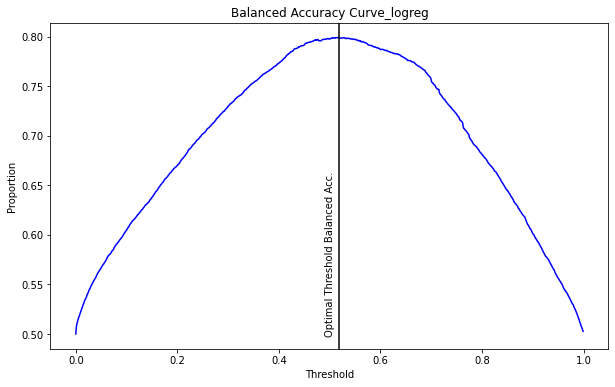

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Balanced Accuracy Score 
plt.figure(figsize=(10,6))
plt.plot(thresholds, scores, color='blue')
plt.title('Balanced Accuracy Curve_logreg')

plt.xlabel('Threshold')

plt.axvline(x=.518, color='black')
plt.text(.49,.50,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('Proportion')
plt.savefig('BAC_LR_cv.png')
plt.show()
files.download('BAC_LR_cv.png')

In [ ]:
from sklearn.metrics import precision_recall_curve,f1_score,accuracy_score,classification_report

In [ ]:
# Calculate Precision and Recall 
precision, recall, thresholds = precision_recall_curve(y_test, probs)
thresholds = np.append(thresholds, 1)

# Define a function to apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t), pos_label=1) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

print('Best Threshold=%.3f, f1-Score=%.5f' % (thresholds[ix], scores[ix]))
print()
print('Classification_Report:')
print(metrics.classification_report(y_test, to_labels(probs, thresholds[ix])))


Best Threshold=0.454, f1-Score=0.83269

Classification_Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76      6868
           1       0.78      0.89      0.83      8429

    accuracy                           0.80     15297
   macro avg       0.81      0.79      0.80     15297
weighted avg       0.81      0.80      0.80     15297



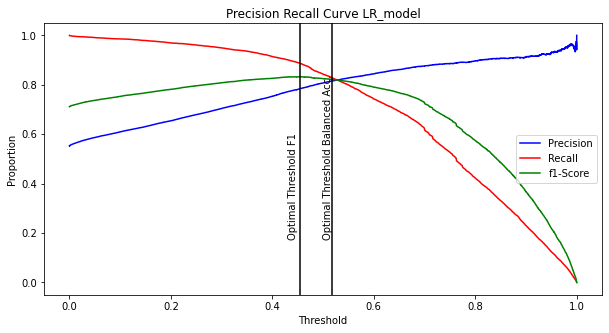

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot Precision, Recall and f1-Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, scores, color='green')
plt.title('Precision Recall Curve LR_model')
plt.legend(('Precision', 'Recall', 'f1-Score'), loc='center right')
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.axvline(x=.454, color='black')
plt.text(.43,0.18,'Optimal Threshold F1',rotation=90)
plt.axvline(x=.518, color='black')
plt.text(.50,.18,'Optimal Threshold Balanced Acc.',rotation=90)
plt.savefig('pcf1_logreg_cv.png',bbox_inches='tight')
plt.show()
files.download('pcf1_logreg_cv.png')

When evaluating models on both business case scenarios and metrics, Logistic Regression Classifier performs better compared to the other two models with a higher Balanced Accuracy score of 0.79933 at an optimal threshold of 0.518 and a higher f1 score of 0.83269 for the positive class at an optimal threshold of 0.454